# Sheet 8

In [113]:
import os
import numpy as np
import torch
from torch import nn
from matplotlib import pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

## 1) Anomaly detection for Autoencoders

In [3]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data06"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "toptagging-short.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data06

100%|██████████| 7/7 [00:00<00:00, 10.30it/s]


 Datentr�ger in Laufwerk C: ist Windows-SSD
 Volumeseriennummer: 22FE-7311

 Verzeichnis von c:\Code\MachineLearningandPhysics\mlph2023-Exercises\data06

20.12.2023  10:31    <DIR>          .
18.12.2023  20:56    <DIR>          ..
18.12.2023  20:56    <DIR>          toptagging-short
19.12.2023  12:10        68.105.824 toptagging-short (1).zip
19.12.2023  12:43        68.105.824 toptagging-short (2).zip
19.12.2023  12:57        68.105.824 toptagging-short (3).zip
19.12.2023  16:42        68.105.824 toptagging-short (4).zip
20.12.2023  10:24        68.105.824 toptagging-short (5).zip
20.12.2023  10:31        68.105.824 toptagging-short (6).zip
18.12.2023  20:56        68.105.824 toptagging-short.zip
               7 Datei(en),    476.740.768 Bytes
               3 Verzeichnis(se), 793.197.547.520 Bytes frei


In [4]:
# load data
X_train = np.load( "data06/toptagging-short/x_train_short.npy")
y_train = np.load( "data06/toptagging-short/y_train_short.npy")
X_test = np.load( "data06/toptagging-short/x_test_short.npy")
y_test = np.load( "data06/toptagging-short/y_test_short.npy")
X_val = np.load( "data06/toptagging-short/x_val_short.npy")
y_val = np.load( "data06/toptagging-short/y_val_short.npy")

print(f"train data shape: {X_train.shape}")
print(f"train labels shape: {y_train.shape}")
print(f"test data shape: {X_test.shape}")
print(f"test labels shape: {y_test.shape}")
print(f"val data shape: {X_val.shape}")
print(f"val labels shape: {y_val.shape}")

train data shape: (30000, 200, 4)
train labels shape: (30000,)
test data shape: (30000, 200, 4)
test labels shape: (30000,)
val data shape: (30000, 200, 4)
val labels shape: (30000,)


In [5]:
# Some initial settings
__n_warning__ = 0.7
n_shift_phi, n_shift_eta = 0, 0

# Grid settings
xpixels = np.arange(-2.6, 2.6, 0.029)
ypixels = np.arange(-np.pi, np.pi, 0.035)

# Calculate the pseudorapidity of pixel entries
def eta (pT, pz):
    small = 1e-10
    small_pT = (np.abs(pT) < small)
    small_pz = (np.abs(pz) < small)
    not_small = ~(small_pT | small_pz)
    theta = np.arctan(pT[not_small]/pz[not_small])
    theta[theta < 0] += np.pi
    etas = np.zeros_like(pT)
    etas[small_pz] = 0
    etas[small_pT] = 1e-10
    etas[not_small] = np.log(np.tan(theta/2))
    return etas

# Calculate the azimuthal angle of pixel entries
def phi (px, py):
    """
    phis are returned in rad., np.arctan(0,0)=0 -> zero constituents set to -np.pi
    """
    phis = np.arctan2(py,px)
    phis[phis < 0] += 2*np.pi
    phis[phis > 2*np.pi] -= 2*np.pi
    phis = phis - np.pi 
    return phis

# function to calculate masses
def mass (E,px,py,pz):
    mass = np.sqrt(np.maximum(0.,E**2-px**2-py**2-pz**2))
    return mass

# function to return the image momenta for centroid and principal axis
def img_mom (x, y, weights, x_power, y_power):
    return ((x**x_power)*(y**y_power)*weights).sum()

# returns the jet image
def orig_image (etas, phis, es):
    """
    Gives the value on grid with minimal distance,
    eg. for xpixel = (0,1,2,3,..) eta=1.3 -> xpixel=1, eta=1.6 ->xpixel=2
    """
    z = np.zeros((etas.shape[0],len(xpixels),len(ypixels)))
    in_grid = ~((etas < xpixels[0]) | (etas > xpixels[-1]) | (phis < ypixels[0]) | (phis > ypixels[-1]))
    xcoords = np.argmin(np.abs(etas[:,None,:] - xpixels[None,:,None]),axis=1)
    ycoords = np.argmin(np.abs(phis[:,None,:] - ypixels[None,:,None]),axis=1)
    ncoords = np.repeat(np.arange(etas.shape[0])[:,None],etas.shape[1],axis=1)
    z[ncoords[in_grid],ycoords[in_grid],xcoords[in_grid]] = es[in_grid]
    return z

# preprocess the jet
def preprocessing( x ,y, weights, rotate=True, flip=True ):
    """
    (x,y) are the coordinates and weights the corresponding values, shifts
    centroid to origin, rotates image, so that principal axis is vertical,
    flips image, so that most weights lay in (x<0, y>0)-plane.
    Method for calculating principal axis (similar to tensor of inertia):
    https://en.wikipedia.org/wiki/Image_moment
    here: y=phi, phi has modulo 2*np.pi but it's not been taken care of hear,
    so possible issues with calculating the centroid
    -> pre-shifting of events outside of this function solves the problem
    for iamge-data with Delta_phi < 2*np.pi
    """

    # Shift
    x_centroid = img_mom(x, y, weights, 1, 0) / weights.sum()
    y_centroid = img_mom(x, y, weights, 0, 1)/ weights.sum()
    x = x - x_centroid
    y = y - y_centroid

    # Check if shifting worked, there can be problems with modulo variables like phi (y)
    # x and y are sorted after highest weight, 0-comp. gives hottest event
    # for Jet-like Images Centroid should be close to hottest constituen (pT-sorted arrays)  
    global n_shift_phi
    global n_shift_eta
    if np.abs(x[0]) > __n_warning__:
        n_shift_eta += 1  
    if np.abs(y[0]) > __n_warning__:
        n_shift_phi += 1       

    if rotate:
        #Ccovariant matrix, eigenvectors corr. to principal axis
        u11 = img_mom(x, y, weights, 1, 1) / weights.sum()
        u20 = img_mom(x, y, weights, 2, 0) / weights.sum()
        u02 = img_mom(x, y, weights, 0, 2) / weights.sum()
        cov = np.array([[u20, u11], [u11, u02]])

        # Eigenvalues and eigenvectors of covariant matrix
        evals, evecs = np.linalg.eig(cov)

        # Sorts the eigenvalues, v1, [::-1] turns array around, 
        sort_indices = np.argsort(evals)[::-1]
        e_1 = evecs[:, sort_indices[0]]  # Eigenvector with largest eigenvalue
        e_2 = evecs[:, sort_indices[1]]

        # Theta to x_asix, arctan2 gives correct angle
        theta = np.arctan2(e_1[0], e_1[1])
  
        # Rotation, so that princple axis is vertical
        # anti-clockwise rotation matrix
        rotation = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
        transformed_mat = rotation * np.stack([x,y])
        x_rot, y_rot = transformed_mat.A
    else: 
        x_rot, y_rot = x, y
  
    # Flipping
    n_flips = 0
    if flip:
        if weights[x_rot<0.].sum() < weights[x_rot>0.].sum():
            x_rot = -x_rot
            n_flips  += 1
        if weights[y_rot<0.].sum() > weights[y_rot>0.].sum():
            y_rot = -y_rot
            n_flips += 1
            
    return x_rot, y_rot


# function to convert the jet to an image
def constit_to_img( jets, n_constit, norm, rotate, flip ):
    
    print( "Crop constituents" )
    jets = jets[:,0:n_constit,:]
    
    print( "Calculating pT" )
    E     = jets[:,:,0]
    pxs   = jets[:,:,1]
    pys   = jets[:,:,2]
    pzs   = jets[:,:,3]
    pT    = np.sqrt(pxs**2+pys**2)
    
    print( "Calculating eta" )
    etas  = eta(pT,pzs)
    
    print( "Calculating phi" )
    phis  = phi(pxs,pys)
    
    print( "Calculating the mass" )
    E_tot = E.sum(axis=1)
    px_tot = pxs.sum(axis=1)
    py_tot = pys.sum(axis=1)
    pz_tot = pzs.sum(axis=1)
    j_mass = mass(E_tot, px_tot, py_tot, pz_tot)
    
    print( "Pre-shifting the phis" )
    phis = (phis.T - phis[:,0]).T
    phis[phis < -np.pi] += 2*np.pi
    phis[phis > np.pi] -= 2*np.pi
    
    print( "Using pT as weight" )
    weights = pT
    
    print( "Preprocessing" )
    
    for i in range( np.shape(etas)[0] ):
        etas[i,:], phis[i,:] = preprocessing( etas[i,:], phis[i,:], weights[i,:], rotate, flip )
    
    print( "Creating images" )
    z_ori = orig_image(etas, phis, weights)
    
    #return z_ori
        
    print( "Cropping and normalising" )
    n_crop = 40
    z_new = np.zeros( (z_ori.shape[0],n_crop, n_crop) )
    for i in range(z_ori.shape[0]):
        Npix = z_ori[i,:,:].shape
        z_new[i,:,:] = z_ori[i, int(Npix[0]/2-n_crop/2) : int(Npix[0]/2+n_crop/2), int(Npix[1]/2-n_crop/2) : int(Npix[1]/2+n_crop/2) ]
        if norm:
            z_sum = z_new[i,:,:].sum()
            if z_sum != 0.:
                z_new[i,:,:] = z_new[i,:,:]/z_sum
    
    print( "Reshaping" )
    z_out = z_new.reshape( (z_new.shape[0],-1) ).reshape(-1, 1, 40,40)
    
    return z_out

In [6]:
z_train = constit_to_img( X_train, 50, True, True, True )
z_val = constit_to_img( X_val, 50, True, True, True )
z_test = constit_to_img( X_test, 50, True, True, True )

Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping
Crop constituents
Calculating pT
Calculating eta
Calculating phi
Calculating the mass
Pre-shifting the phis
Using pT as weight
Preprocessing
Creating images
Cropping and normalising
Reshaping


(a)

In [70]:
# TODO: Construct autoencoder
#define the autoencoder class
class AE(torch.nn.Module):
    def __init__(self, enc_dims, dec_dims):
        
        super().__init__()
        #the first entry of enc_dims is the size of the input layer and the last entry of dec_dims is the size of the output layer
        #make sure the dimensions of the encoder and decoder are compatible (input = output and bottleneck layer is the same)
        assert enc_dims[-1] == dec_dims[0]
        assert enc_dims[0] == dec_dims[-1]

        #Encoder
        enc_layers=[]
        for n_layer in range(len(enc_dims)-1):
            enc_layers.append(nn.Linear(enc_dims[n_layer], enc_dims[n_layer + 1]))
            enc_layers.append(nn.ReLU())
        self.encoder =  nn.Sequential(*enc_layers)
        
        #Decoder
        dec_layers = []
        for n_layer in range(len(dec_dims)-2):
            dec_layers.append(nn.Linear(dec_dims[n_layer], dec_dims[n_layer + 1]))
            dec_layers.append(nn.ReLU())
        dec_layers.append(nn.Linear(dec_dims[-2], dec_dims[-1]))
        dec_layers.append(nn.Sigmoid())
        self.decoder =  nn.Sequential(*dec_layers)
        
    def forward(self, x):
        bottleneck = self.encoder(x)
        out = self.decoder(bottleneck)
        return out

C:\Users\phili\AppData\Local\Temp\ipykernel_26680\2116318392.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


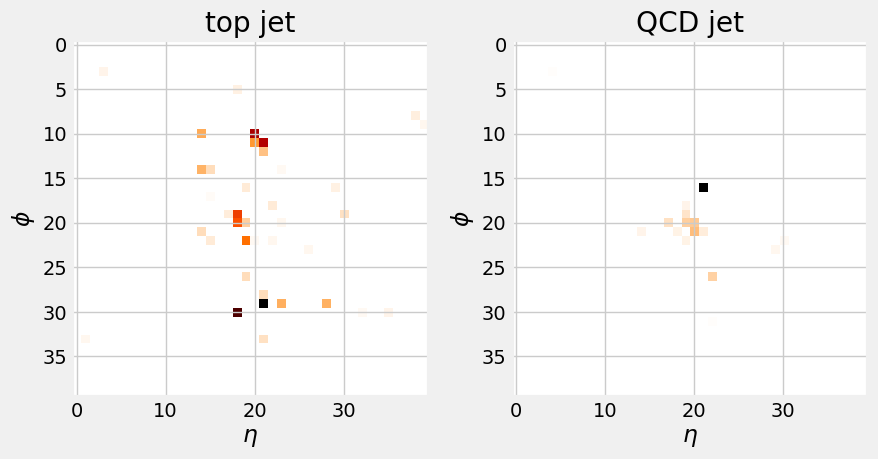

In [59]:
#Visualize the data again
sig = z_train[ np.where(y_train==1) ]
bkg = z_train[ np.where(y_train==0) ]

fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( sig[0,0,...], cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("top jet")

axs[1].imshow( bkg[0,0,...], cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("QCD jet")

fig.tight_layout()

fig.show()

C:\Users\phili\AppData\Local\Temp\ipykernel_26680\773236851.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


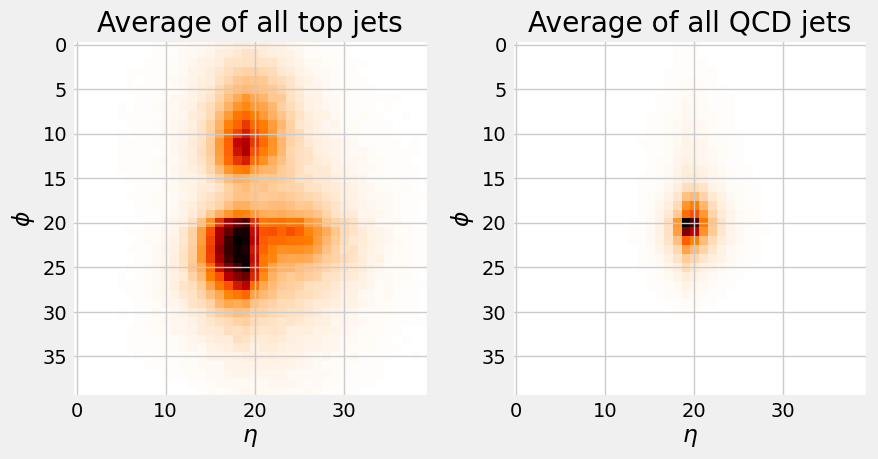

In [60]:
fig, axs = plt.subplots( 1, 2, figsize=(9,5) )

axs[0].imshow( sig.mean(0)[0,...], cmap="gist_heat_r" )
axs[0].set_xlabel( "$\eta$" )
axs[0].set_ylabel( "$\phi$" )
axs[0].set_title("Average of all top jets")

axs[1].imshow( bkg.mean(0)[0,...], cmap="gist_heat_r" )
axs[1].set_xlabel( "$\eta$" )
axs[1].set_ylabel( "$\phi$")
axs[1].set_title("Average of all QCD jets")

fig.tight_layout()

fig.show()

(b)

In [101]:
# make the dataloaders

#define the dataset class
class AE_data( torch.utils.data.Dataset ):
    
    def __init__( self, imgs):
        self.imgs = imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        return self.imgs[idx]
    
def make_dataloaders(z_train, z_val, z_test, batch_size):
    # flatten datasets of the signal 
    nev = z_train.shape[0]
    z_train_f = np.reshape(z_train, (nev, -1))
    z_val_f = np.reshape(z_val, (nev, -1))
    z_test_f = np.reshape(z_test, (nev, -1))

    #convert data to torch tensors
    z_train_torch = torch.Tensor(z_train_f).float()
    z_test_torch = torch.Tensor(z_test_f).float()
    z_val_torch = torch.Tensor(z_val_f).float()

    train_AE_dataset = AE_data(z_train_torch)
    test_AE_dataset = AE_data(z_test_torch)
    val_AE_dataset = AE_data(z_val_torch)
    #define the dataloaders
    trn_dataloader = torch.utils.data.DataLoader( train_AE_dataset, batch_size = batch_size, shuffle=True )
    tst_dataloader = torch.utils.data.DataLoader( test_AE_dataset, batch_size= batch_size, shuffle=False )
    val_dataloader = torch.utils.data.DataLoader( val_AE_dataset, batch_size= batch_size, shuffle=False )

    return trn_dataloader, tst_dataloader, val_dataloader, z_train_torch, z_test_torch, z_val_torch

In [103]:
#make dataloaders with top jet data only
top_train = z_train[ np.where(y_train==1) ]
top_val = z_val[ np.where(y_train==1) ]
top_test = z_test[ np.where(y_train==1) ]

trn_dataloader_top,tst_dataloader_top,val_dataloader_top,_,_,_=make_dataloaders(top_train,top_val,top_test,64)

#make dataloaders with top jet data only
qcd_train = z_train[ np.where(y_train==0) ]
qcd_val = z_val[ np.where(y_train==0) ]
qcd_test = z_test[ np.where(y_train==0) ]

trn_dataloader_qcd, tst_dataloader_qcd, val_dataloader_qcd,_,_,_ = make_dataloaders(qcd_train, qcd_val, qcd_test, 64)

In [226]:
# 
#TODO: Train autoencoder on QCD jets
# Choose the bottleneck dimension between 5 and 20

#define the training loop
def train(AE_model, n_epochs, trn_dataloader, val_dataloader, optimizer, loss_fn):
    outputs = []
    train_losses = []
    val_losses=[]
    for epoch in range(n_epochs):
        for (image) in trn_dataloader:
        
            # Output of Autoencoder
            reconstructed = AE_model(image)
            
            # Calculating the loss function
            loss = loss_fn(reconstructed, image)
            
            # The gradients are set to zero,
            # the gradient is computed and stored.
            # .step() performs parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Storing the losses in a list for plotting
            train_losses.append(loss.detach())

        #also calculate the mean losses for each epoch in the validation dataset
        for val_image in val_dataloader:
            epoch_losses = []
            val_reconstructed = AE_model(val_image)
            epoch_loss = loss_fn(val_reconstructed, val_image)
            epoch_losses.append(epoch_loss.detach())
        val_losses.append(np.mean(epoch_losses))
            

        #storing the inputs and outputs for each epoch in an array
        outputs.append((epoch, image, reconstructed))
        if epoch%1==0:
            print(f"{epoch} / {n_epochs}")
    return train_losses,val_losses, outputs


 

In [256]:
#initialize the network
enc_dims = [40*40, 20*20, 10*10, 10]  #works okay, gives AUC of 74% with 50 epochs, which is better than random at least 
dec_dims = [10, 10*10, 20*20, 40*40]
n_epochs = 100

model = AE(enc_dims, dec_dims)
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")
# print(z_train.shape)
# print(z_val.shape)
# print(X_train.shape)
# plt.imshow(z_train[13000, 0, :, :])

#do the actual training
# using MSE Loss function
loss_function = torch.nn.MSELoss()
# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#do the training on the qcd jets:
qcd_losses,qcd_val_losses, qcd_outputs = train(model, n_epochs, trn_dataloader_qcd,val_dataloader_qcd, optimizer, loss_function)



AE(
  (encoder): Sequential(
    (0): Linear(in_features=1600, out_features=400, bias=True)
    (1): ReLU()
    (2): Linear(in_features=400, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=400, bias=True)
    (3): ReLU()
    (4): Linear(in_features=400, out_features=1600, bias=True)
    (5): Sigmoid()
  )
)
Model has 1364610 trainable parameters
0 / 100
1 / 100
2 / 100
3 / 100
4 / 100
5 / 100
6 / 100
7 / 100
8 / 100
9 / 100
10 / 100
11 / 100
12 / 100
13 / 100
14 / 100
15 / 100
16 / 100
17 / 100
18 / 100
19 / 100
20 / 100
21 / 100
22 / 100
23 / 100
24 / 100
25 / 100
26 / 100
27 / 100
28 / 100
29 / 100
30 / 100
31 / 100
32 / 100
33 / 100
34 / 100
35 / 100
36 / 100
37 / 100
38 / 100
39 / 100
40 / 100
41 / 100
42 / 100
43 / 100
44 / 100
45 / 100
46 / 100
47 / 100
48 /

The configuration above with a bottleneck size of 10 works okay. At 50 epochs, AUC = 0.74 can be achieved. Increasing to 100 epochs does not improve the result further

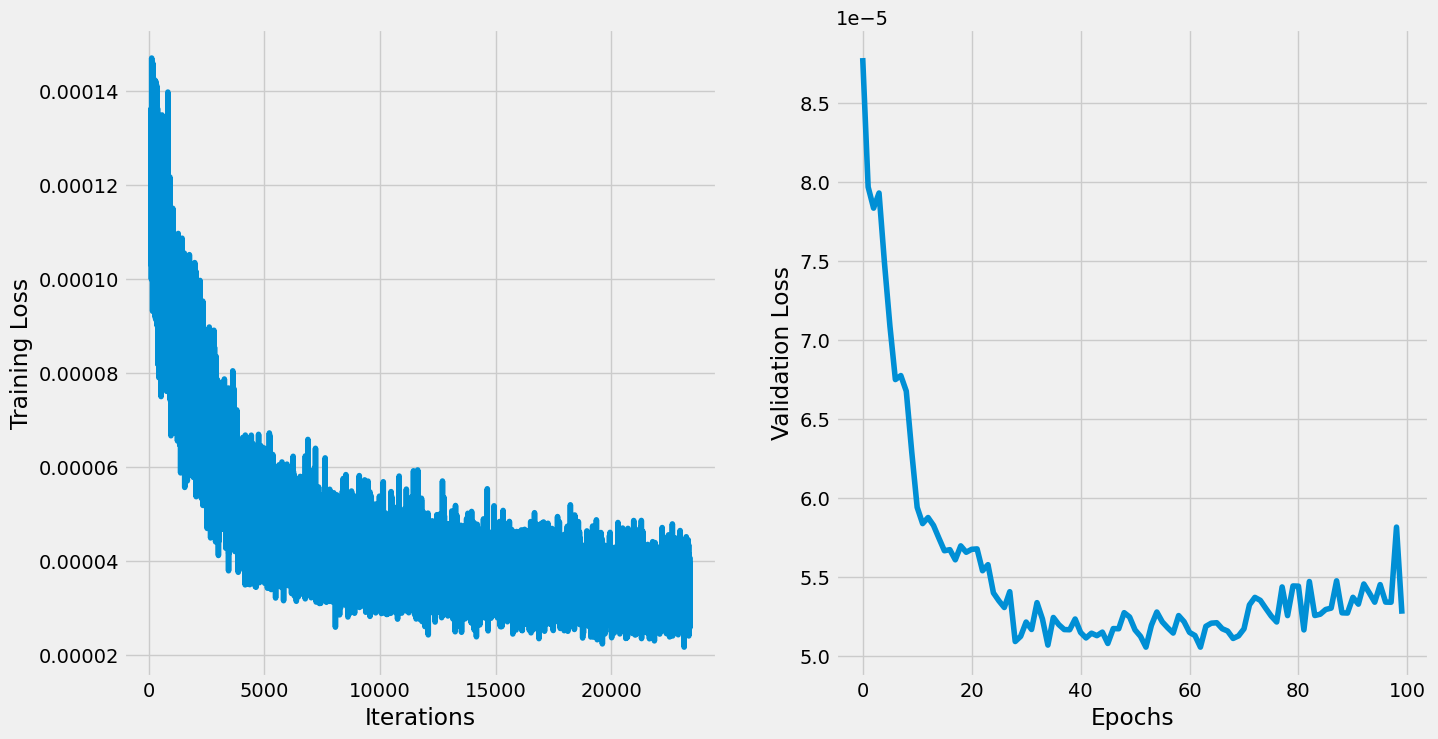

In [257]:
# Defining the Plot Style
fig, axs = plt.subplots(1,2, figsize=(15,8))
axs[0].set_xlabel('Iterations')
axs[0].set_ylabel('Training Loss')
axs[0].plot(np.arange(100,len(qcd_losses),1),qcd_losses[100:])

axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Validation Loss')
axs[1].plot(qcd_val_losses)

 


c)


In [258]:
#extract the first four top and qcd jets from the test data
First4TopJets = top_val[:4,...]
First4QCDJets = qcd_val[:4,...]
#Flatten the data
First4TopJets_f = np.reshape(First4TopJets, (4,-1))
First4QCDJets_f = np.reshape(First4QCDJets, (4,-1))
#turn into tensors
First4TopJets_f = torch.tensor(First4TopJets_f).float()
First4QCDJets_f = torch.tensor(First4QCDJets_f).float()


In [259]:
#Generate the model outputs
with torch.no_grad():
    First4TopPreds_f = model(First4TopJets_f)
    First4QCDPreds_f = model(First4QCDJets_f)

#Reshape to get the image again
First4TopPreds = np.reshape(First4TopPreds_f, (4, 40, 40))
First4QCDPreds = np.reshape(First4QCDPreds_f, (4, 40, 40))
print(First4TopPreds.shape)

torch.Size([4, 40, 40])


C:\Users\phili\AppData\Local\Temp\ipykernel_26680\18744333.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


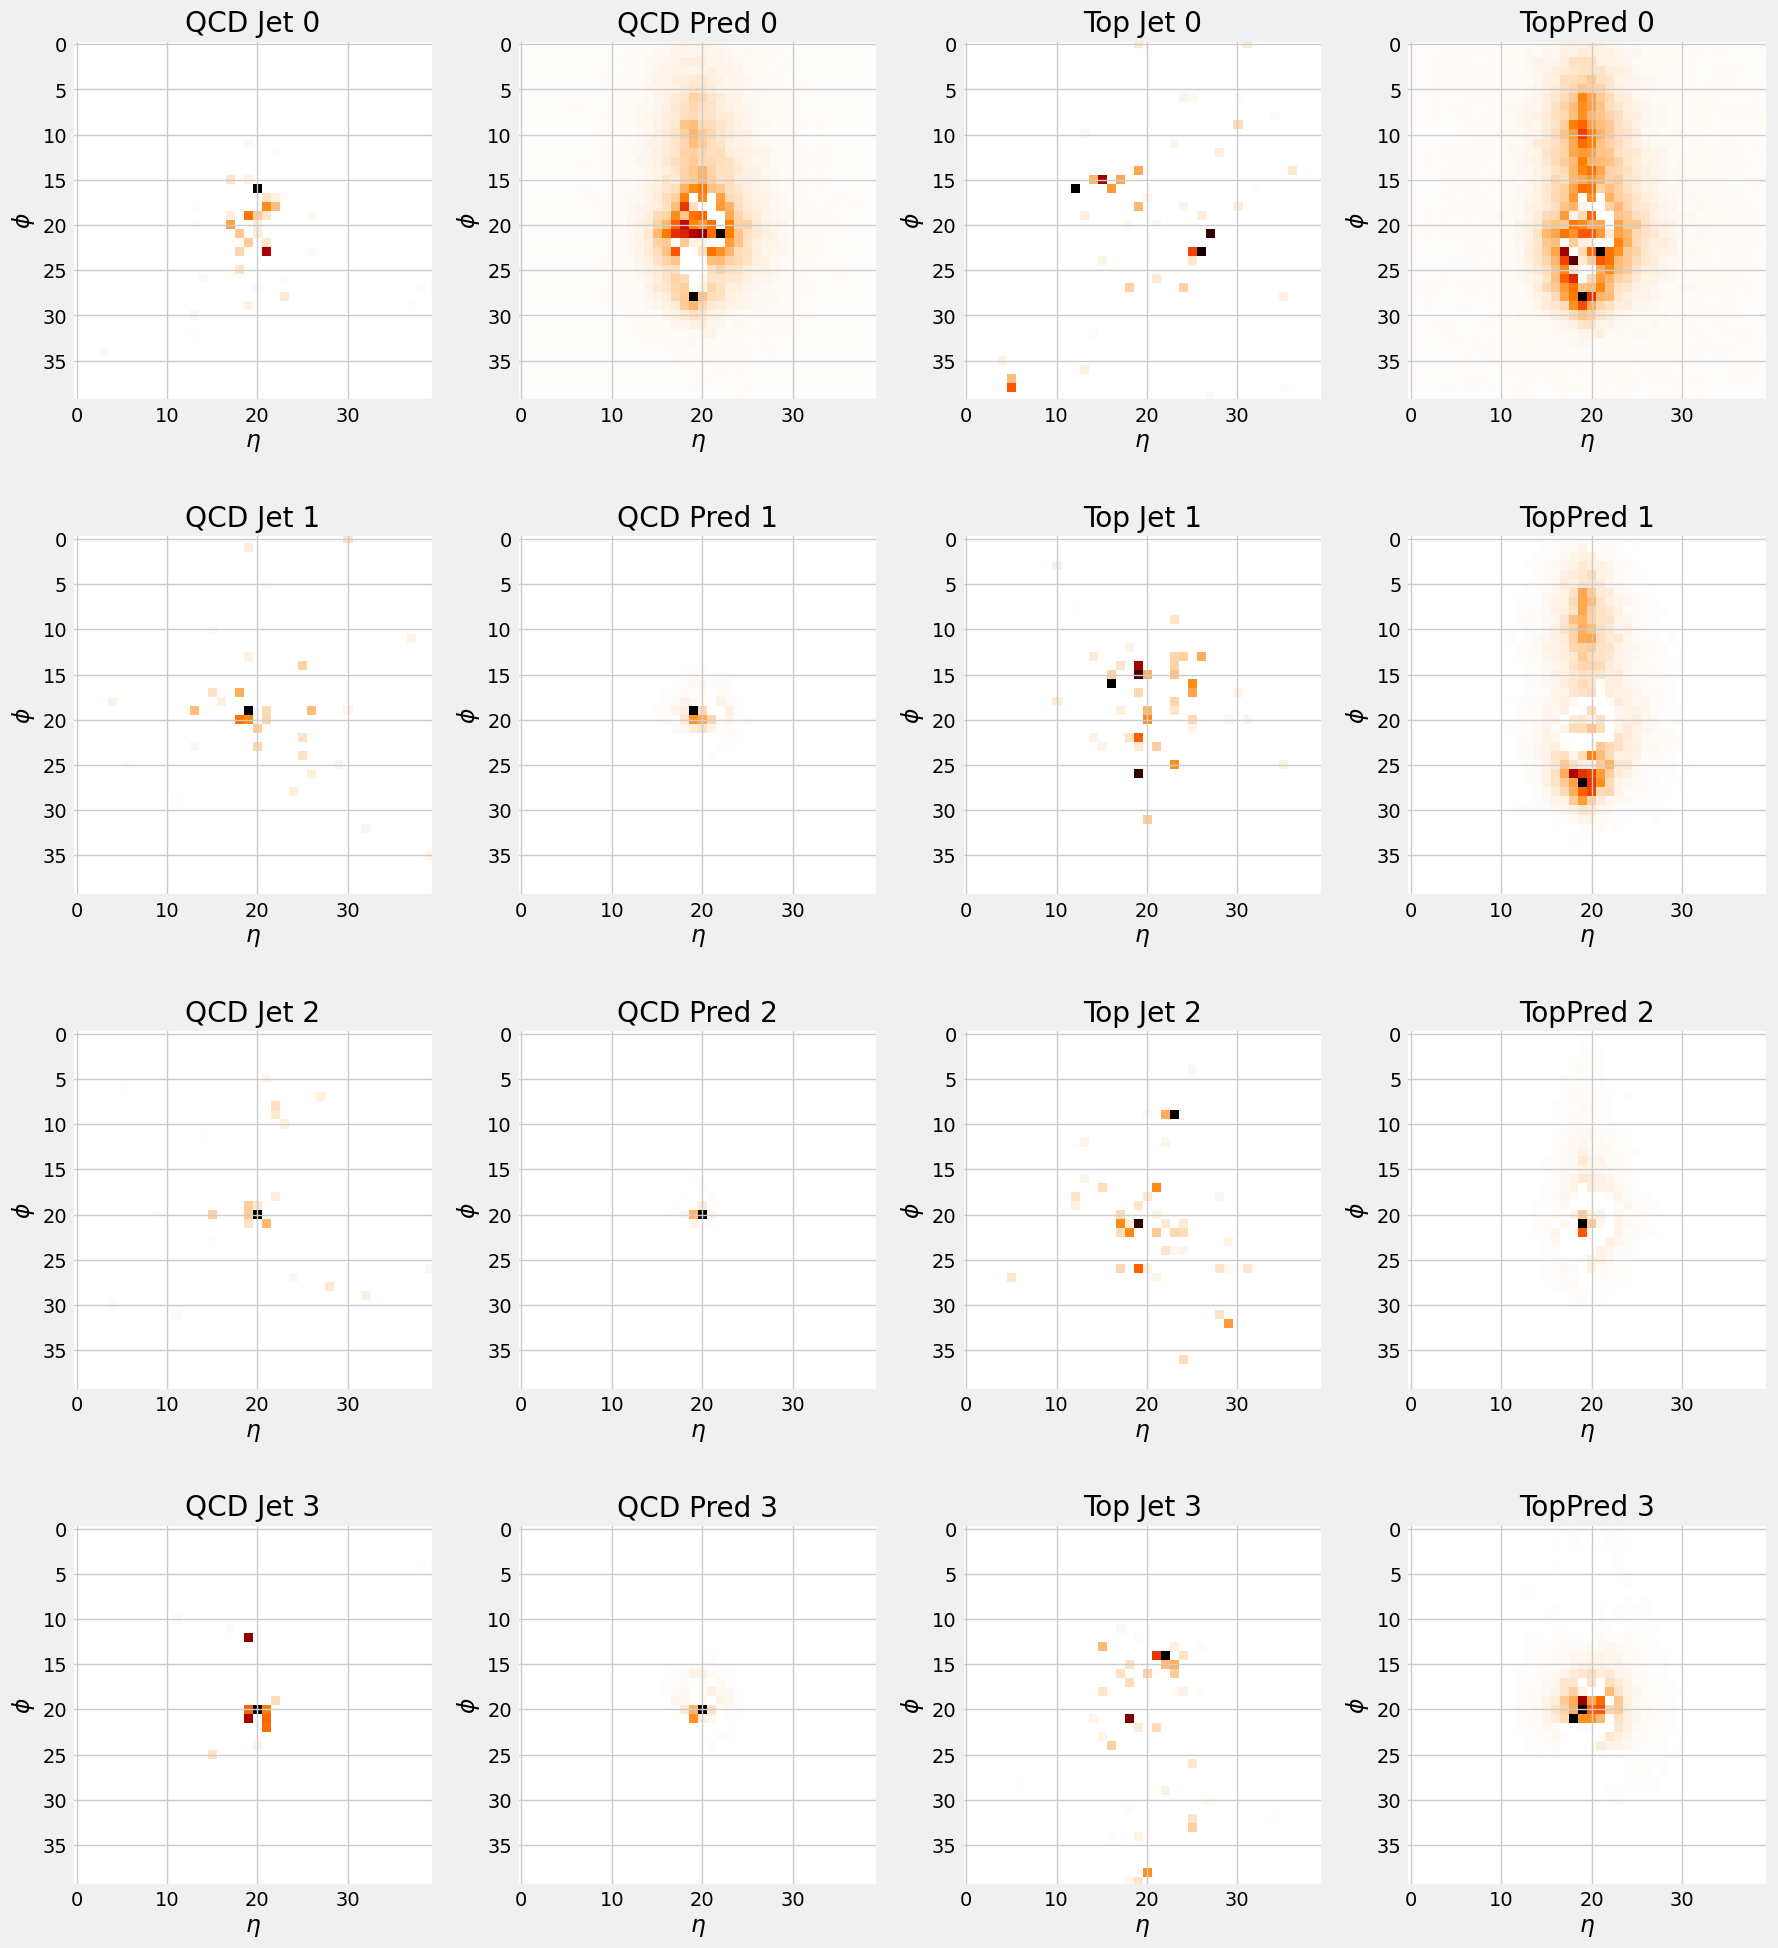

In [260]:
#visualize

fig, axs = plt.subplots( 4, 4, figsize=(18,20) )

First4Labels = ["QCD Jet " ,"QCD Pred ", "Top Jet ", "TopPred "]
First4 = [First4QCDJets[:,0,...], First4QCDPreds.numpy(),First4TopJets[:,0,...], First4TopPreds.numpy()]

for i in range(4):
    for j in range(4):
        axs[i, j].imshow(First4[j][i,...], cmap="gist_heat_r" )
        axs[i,j].set_xlabel( "$\eta$" )
        axs[i,j].set_ylabel( "$\phi$" )
        axs[i,j].set_title(First4Labels[j]+str(i))

fig.tight_layout()

fig.show()
# fig.savefig("sigmoid")

Predictions look a lot like the average plots from above. The QCD Jets are reconstructed much better than the Top Jets, which was expected

(d)

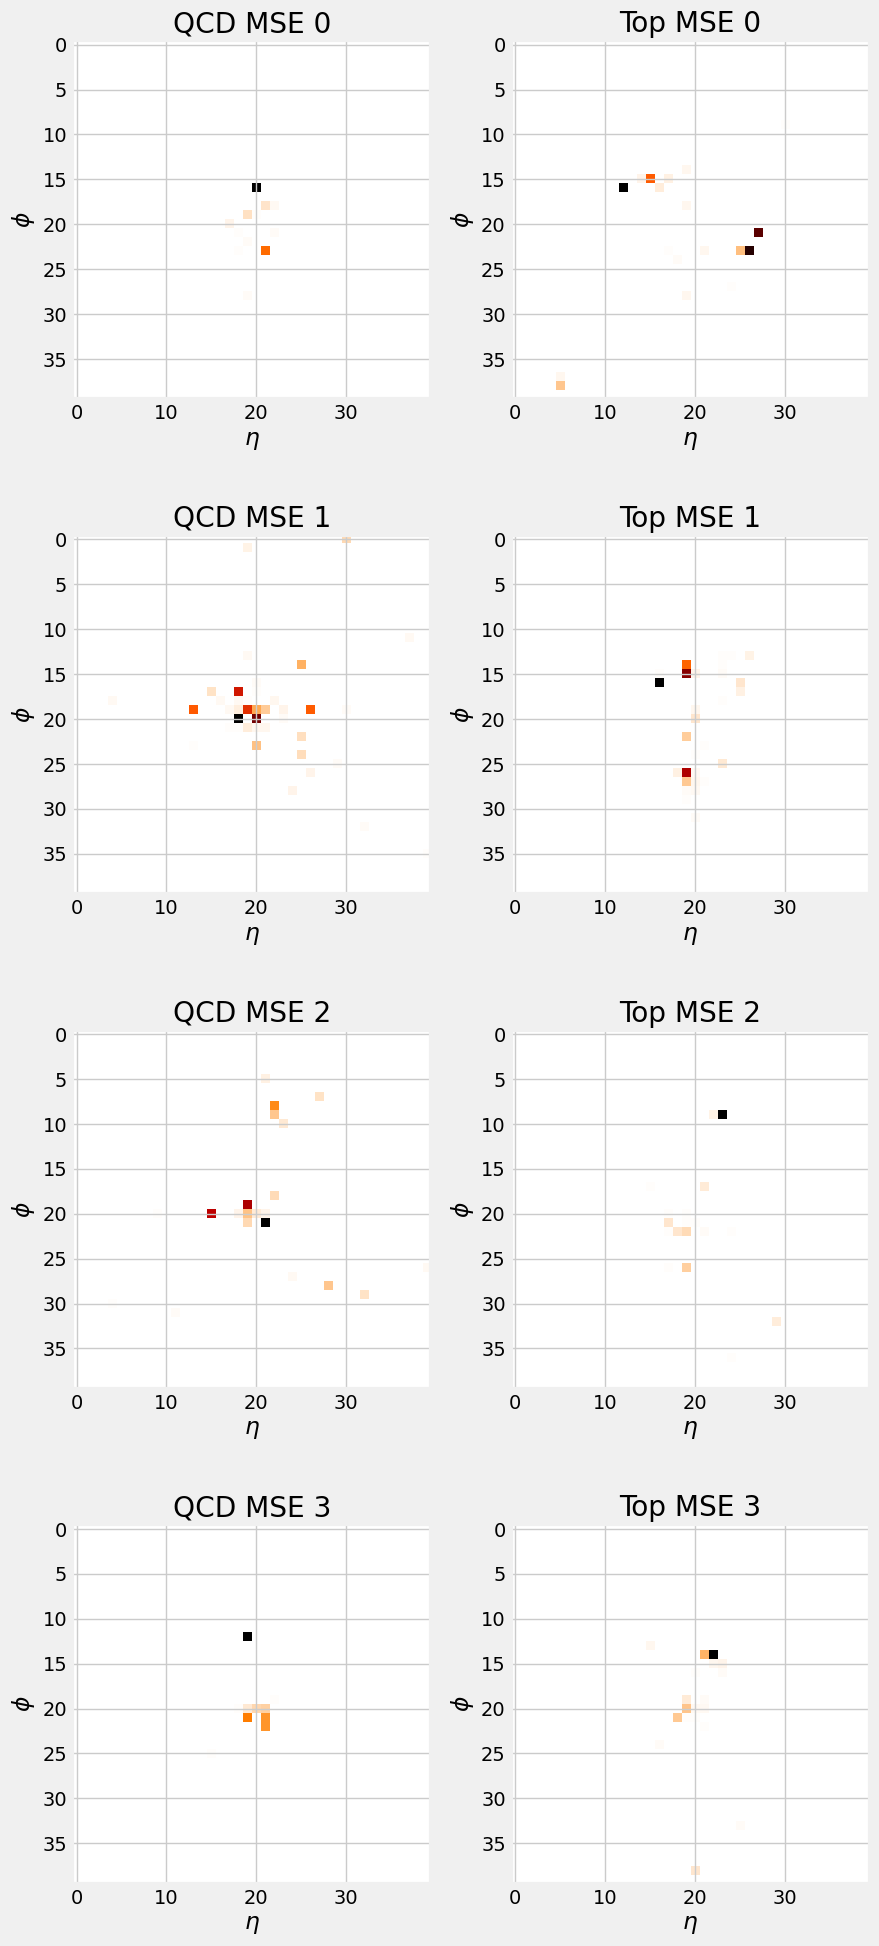

In [261]:
# TODO: Visualize pixel-wise MSE, plot ROC
fig, axs = plt.subplots( 4, 2, figsize=(9,20) )

Labels = ["QCD MSE " ," ", "Top MSE "]
First4 = [First4QCDJets[:,0,...], First4QCDPreds.numpy(),First4TopJets[:,0,...], First4TopPreds.numpy()]

for i in range(4):
    for j in [0,1]:
        axs[i, j].imshow((First4[2*j][i,...]-First4[2*j+1][i,...])**2, cmap="gist_heat_r" )
        axs[i,j].set_xlabel( "$\eta$" )
        axs[i,j].set_ylabel( "$\phi$" )
        axs[i,j].set_title(Labels[2*j]+str(i))

fig.tight_layout()

In [262]:
#ROC curves etc.
#get the data
_,_,_,z_train_torch,z_test_torch,z_val_torch=make_dataloaders(z_train,z_val,z_test,64)

with torch.no_grad():
    #make prediction
    test_pred = model(z_test_torch)
    #calculate MSE
    test_MSE = torch.mean((z_test_torch - test_pred)**2, 1)
    #normalize MSE
    test_MSE = test_MSE / torch.max(test_MSE)
    #convert the labels to tensor
    y_test_torch = torch.Tensor(y_test).float()
#what is the MSE difference between top jets and qcd jets?
mean_MSE_qcd = torch.mean(test_MSE[np.where(y_test_torch == 0)])
mean_MSE_top = torch.mean(test_MSE[np.where(y_test_torch == 1)])
print("Mean MSE of qcd images: " + str(mean_MSE_qcd.numpy()))
print("Mean MSE of top images: " + str(mean_MSE_top.numpy()))
#compute ROC and AUC
fpr, tpr, th = roc_curve(y_test_torch, test_MSE)
auc_score = roc_auc_score(y_test_torch, test_MSE)

Mean MSE of qcd images: 0.07306789
Mean MSE of top images: 0.10181381


As we can see, the mean MSE is considerably larger for the top jets. This means that the reconstruction works better for the qcd jets, which is what we expect as thats what the network was trained on.

Text(0.5, 1.0, 'ROC curve of AE with MSE discriminator')

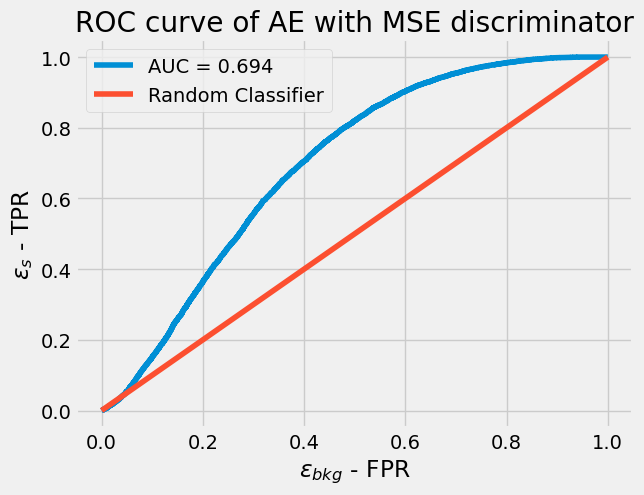

In [263]:
#plot the ROC
fig, ax = plt.subplots()
rnd_class = np.linspace(0, 1, 100)

ax.plot(fpr, tpr, label = f"AUC = {auc_score:.3}")
plt.plot(rnd_class,rnd_class, label = "Random Classifier")
ax.set_xlabel('$\epsilon_{bkg}$ - FPR')
ax.set_ylabel('$\epsilon_{s}$ - TPR')
ax.legend()
ax.set_title("ROC curve of AE with MSE discriminator")

(e)

In [268]:
# TODO: Repeat everything for CNN
#construct the autoencoder
class ConvAE(nn.Module):
    def __init__(self, bttlneck):
        super().__init__()
        #encoding section 
        self.encoder = nn.Sequential(
            nn.conv2d(1, 10, kernel_size=5, bias=True, stride=1, padding=2),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.PReLU(),
            nn.conv2d(10,5, kernel_size=5, bias=True, stride=1, padding=2),
            nn.PReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.PReLU(),
            nn.conv2d(5,1,kernel_size=3, bias=True, stride=1, padding=1),
            nn.PReLU(),
            nn.Flatten(),
            nn.Linear(100, bttlneck),
            nn.Sigmoid()
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(bttlneck, 100),
            nn.PReLU(),
            nn.Unflatten(dim = 1, unflattened_size=(10,10)),
            nn.ConvTranspose2d(1, 5,kernel_size=3, bias=True, stride=1, output_padding=1),
            nn.PReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.PReLU(),
            nn.ConvTranspose2d(5,10,kernel_size=5, bias=True, stride=1, output_padding=2),
            nn.PReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.PReLU(),
            nn.UpsamplingNearest2d(scale_factor=2),
            nn.ConvTranspose2d(10,1, kernel_size=5, bias=True, output_padding=0)
        )
    def forward(self, x):
        latent = self.encoder(x)
        out = self.decoder(latent)
        return out
        

The above autoencoder was modelled after figure 25 in the script

(f)

In [265]:
# TODO: Repeat everything for autoencoder trained on top jets
# You can either use a MLP or a CNN